<a href="https://colab.research.google.com/github/miaomiaozhang20/ec970_spring2024/blob/main/Langchain_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangChain Overview

#### Modular Design

LangChain follows a modular design philosophy, allowing developers to easily combine and customize different components to create tailored LLM-based applications. The library provides a wide range of building blocks, such as models, prompts, chains, and agents, which can be seamlessly integrated to build complex workflows.

#### Support for Multiple LLMs

LangChain supports various LLMs, including OpenAI's GPT models, Hugging Face's transformers, and custom models. This flexibility enables developers to choose the most suitable LLM for their specific use case, whether it's a pre-trained model or a custom-trained one.

#### Prompt Engineering

LangChain places a strong emphasis on supporting prompt engineering. The library provides a `PromptTemplate` class that allows developers to define and manage prompts easily. Prompts can include variables, which are dynamically filled with specific values during runtime, enabling dynamic and context-aware interactions.

#### Chains and Workflows

LangChain introduces the concept of chains, a series of steps defining the workflow of a language-based application. Chains allow developers to combine multiple components, such as models, prompts, and memory, into a coherent application pipeline. The library offers various built-in chains, such as the `LLMChain` for basic LLM interactions, the `MapReduceChain` for parallel processing of documents, and the `ConversationChain` for building conversational agents.

#### Agents and Decision-Making

LangChain provides a framework for creating *agents*. Agents are higher-level abstractions that combine models, prompts, and chains to perform complex tasks. Agents can make decisions based on the input and context, interact with external tools or APIs, and generate appropriate responses. The library offers a set of predefined agents, such as the `ZeroShotAgent` and the `ReActAgent`, which can be customized and extended to suit specific use cases.

#### Memory and Context Awareness

LangChain includes a memory component that allows chains and agents to store and retrieve relevant information across multiple interactions. This is particularly useful for building chatbots or systems that require such capabilities. The library provides different types of memory which can be easily integrated into chains and agents.

### Using LLMs for Extracting Forecasting Data

Forecasting models often rely on structured historical data, but a vast amount of relevant information often exists in unstructured formats, such as news articles, social media posts, and customer reviews. LangChain and LLMs customized by prompting enable developers to build applications automatically extracting pertinent information from these unstructured sources. This makes them useful for forecasting models without creating custom natural language processing (NLP) capabilities for the specific use case.

Consider, for example, the following text scraped from the Internet: "Gov Capital's 2024 Forecast for Nvidia's Stock Price

Price Range for 2024: $389.58-$872.59 (as for February 19, 2024). Gov Capital predicts Nvidia's stock to reach $752.21 by December 2024, marking a 60.89% increase from the current price. This optimistic forecast is based on a custom deep learning algorithm that analyzes market trends, volume, and price changes, reflecting Nvidia's strong performance over the past year and suggesting a promising addition to investment portfolios." In this section, we will demonstrate how to use LLMs to extract and summarize stock price forecasts from such unstructured text and obtain the core information required for forecasting in structured JSON format. For this specific text, the JSON should look like the following:

```json
{
  "source": "Gov Capital",
  "price_range": {
    "low": 389.58,
    "high": 872.59
  },
  "forecast_issued_date": "2024-02-19",
  "forecast_target_date": "2024-12-31"
}
```
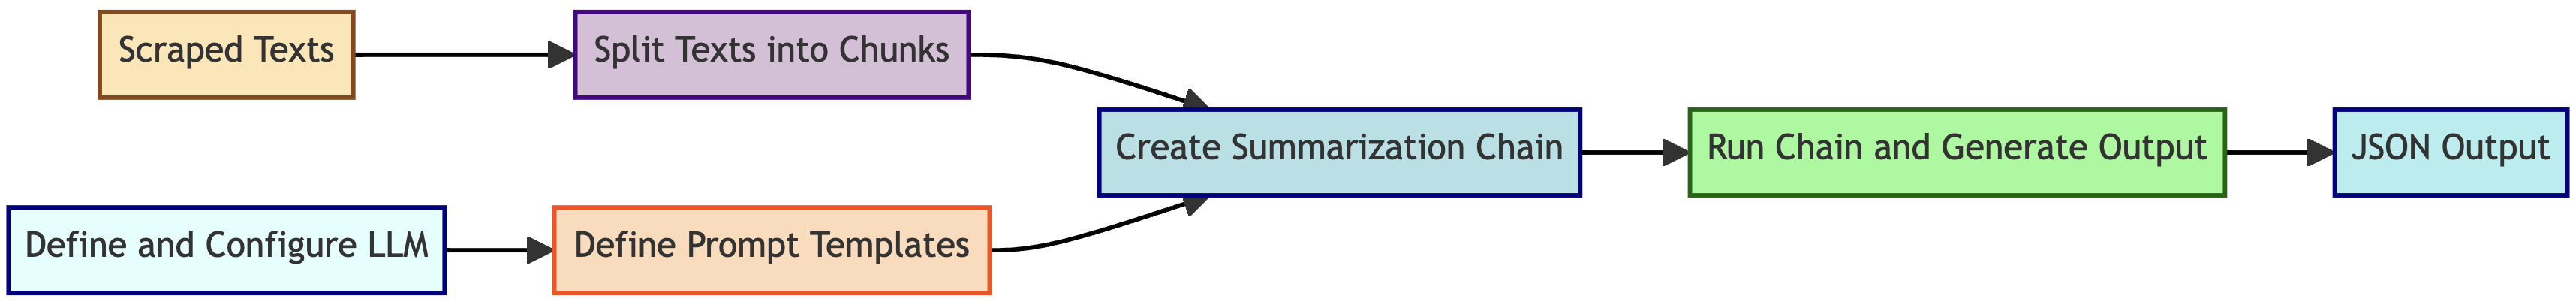

We show how to do this using the OpenAI GPT-4-turbo model and implementing a LangChain-based analytics chain to extract the data according to the flow in the diagram above. The process for creating and running this chain is detailed in the steps that follow.



# Chains

In [ ]:
!pip install openai
!pip install tiktoken
!pip install langchain
!pip install langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: packag

In [ ]:
from langchain import OpenAI, PromptTemplate, LLMChain
from langchain.chains.mapreduce import MapReduceChain
from langchain.prompts import PromptTemplate
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain
from langchain_openai import ChatOpenAI

import json
from langchain.text_splitter import CharacterTextSplitter
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain.chains.summarize import load_summarize_chain



In [ ]:
# Define the LLM
llm = ChatOpenAI(openai_api_key = 'yourkey', model_name = 'gpt-4-turbo', temperature=1.)

# Stock Price Forecast

In [ ]:
forecast_report = '''Gov Capital's 2024 Forecast for Nvidia’s Stock Price
Price Range for 2024: $389.58–$872.59 (as for February 19, 2024)

Gov. Capital forecasts Nvidia's stock to reach $752.21 by December 2024, a 60.89% increase from the current price level. This bullish prediction is based on a custom deep learning algorithm considering market trends, volume, and price changes. The algorithm's positive outlook reflects Nvidia's strong performance over the past year, suggesting the stock is a promising portfolio addition due to its rising tendency in the market.

StockAnalysis 2024 Forecast for Nvidia’s Stock Price
Price Range for 2024: $195–$1.100 (as for February 19, 2024)

Stockanalysis.com's consensus from 38 analysts sets Nvidia's average 12-month price target at $609.89, predicting a 30.42% rise. The forecast range varies significantly, from $195 to $1,100, demonstrating diverse analyst views. The consensus of a "Strong Buy" rating reflects a general expectation of Nvidia's robust market performance and potential to outperform the market significantly, indicating a highly optimistic outlook for the stock.

WalletInvestor's 2024 Forecast for Nvidia’s Stock Price
Price Range for 2024: $462.705–$586.007 (as for February 19, 2024)

WalletInvestor.com predicts a favorable trajectory for Nvidia (NVDA) stock in 2024, with an expected rise from $467.53 to $586, translating to a long-term earning potential of +25.24%. The year 2024 is anticipated to see fluctuating monthly changes in NVDA's stock price. The forecast reaches a high of $580.85 in November before slightly declining to $574.91 in December. These predictions indicate a generally upward trend for Nvidia's stock throughout the year, with notable increases, especially in May and November, suggesting a robust market performance and a potentially lucrative investment in Nvidia for 2024​​.'''

In [ ]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_text(forecast_report)
docs = [Document(page_content=t) for t in texts]

prompt_template = PromptTemplate(
    input_variables=["text"],
    template="""Extract the source, the forecasted price range for Nvidia's stock in 2024, the date when the forecast is issued, the lead time date of the forecast, and any relevant concise remarks about the context of the forecast from the following text:\n\n{text}"""
)

combine_prompt_template = PromptTemplate(
    input_variables=["text"],
    template="""Combine the extracted forecasts into a JSON format with the entries source, price_range (with low and high), forecast_issued_date (YYYY-MM-DD), forecast_target_date (YYYY-MM-DD), and remarks:
{text}
"""
)

chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=prompt_template, combine_prompt=combine_prompt_template)
result = chain.run(docs)

In [ ]:
file_path = "stock_forecasts.json"

# Write the result directly to the file
with open(file_path, "w") as f:
    f.write(result)

print(f"Stock forecasts saved to {file_path}")

# Print the content of the JSON file
with open(file_path, "r") as f:
    json_content = f.read()
    print("Content of the JSON file:")
    print(json_content)

Stock forecasts saved to stock_forecasts.json
Content of the JSON file:
```json
{
  "forecasts": [
    {
      "source": "Gov Capital",
      "price_range": {
        "low": 389.58,
        "high": 872.59
      },
      "forecast_issued_date": "2024-02-19",
      "forecast_target_date": "2024-12-31",
      "remarks": "Gov Capital projects Nvidia's stock to potentially rise up to $752.21 by the end of December 2024, based on advanced algorithms considering market trends and past performance. Their prediction indicates an increase of 60.89%, recommending it as a strong investment choice."
    },
    {
      "source": "StockAnalysis",
      "price_range": {
        "low": 195,
        "high": 1100
      },
      "forecast_issued_date": "2024-02-19",
      "forecast_target_date": "2024-12-31",
      "remarks": "StockAnalysis provides a wide predicted price range for Nvidia in 2024 with no specific algorithmic analysis or detailed rationale disclosed, focusing less on precise predictions."


### Quarterly Business Review

Here is another use case with the same type of code.

In [ ]:
text = '''Quarterly Business Review - Q2 2023

In the second quarter of 2023, our company experienced significant growth and achieved several key milestones. Our revenue increased by 15% year-over-year, reaching $10.5 million. This growth was primarily driven by our expansion into new markets and the launch of our latest product line.

Our customer acquisition rate also saw a notable improvement, with a 20% increase compared to the previous quarter. We onboarded 750 new customers, bringing our total customer base to 5,000. The average order value (AOV) increased by 8% to $1,200, contributing to our overall revenue growth.

In terms of operational efficiency, we managed to reduce our order processing time by 25%, from an average of 4 days to 3 days. This improvement was a result of the successful implementation of our new automated order management system. Additionally, our inventory turnover ratio increased from 3.5 to 4.2, indicating better inventory management and reduced holding costs.

Looking ahead, we aim to maintain our revenue growth rate above 12% for the next quarter and increase our market share by 5% by the end of the year. We will also focus on further improving our operational metrics, targeting a 10% reduction in order processing time and a 15% increase in inventory turnover ratio.'''

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_text(text)

In [ ]:
# Create Document objects from the text chunks
docs = [Document(page_content=t) for t in texts]


# Define the prompt templates
prompt_template = PromptTemplate(
    input_variables=["text"],
    template="Extract the key metrics and KPIs mentioned in the following text:\n\n{text}"
)

combine_prompt_template = PromptTemplate(
    input_variables=["text"],
    template="Combine the extracted metrics and KPIs into a summary:\n\n{text}"
)

# Load the summarize chain
chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=prompt_template, combine_prompt=combine_prompt_template)

# Run the chain on the Document objects
result = chain.run(docs)

print(result)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


The summary of the key metrics and KPIs from the text indicates a strong performance and ambitious targets for the upcoming periods. Here's a consolidated overview:

1. **Revenue Growth**: The company has achieved a significant increase in revenue, growing by 15% year-over-year to reach $10.5 million. Looking ahead, the target is set to maintain a growth rate above 12% for the next quarter.

2. **Customer Acquisition Rate**: There has been a notable increase of 20% in the customer acquisition rate compared to the previous quarter, contributing to the expansion of the total customer base.

3. **Total Customer Base**: The customer base has expanded to 5,000, bolstered by the addition of 750 new customers, reflecting effective marketing and customer engagement strategies.

4. **Average Order Value (AOV)**: The AOV has risen by 8% to $1,200, indicating an increase in the value of transactions per customer.

5. **Order Processing Time**: Efficiency in order processing has improved, with a r

In [ ]:
text = '''
Market research indicates a growing demand for eco-friendly, sustainable home cleaning products. Consumers are increasingly conscious of the environmental impact of traditional cleaning products and are seeking alternatives that align with their values. A survey conducted by GreenClean Inc. found that 68% of respondents would be willing to pay a premium for environmentally friendly cleaning products.

The potential market for sustainable cleaning products is estimated to be worth $10 billion by 2025, with a projected annual growth rate of 7%. Key demographics driving this demand include millennials and Gen Z, who prioritize sustainability and are willing to invest in products that reduce their carbon footprint.

Competitors in the eco-friendly cleaning space have reported strong sales growth, with some brands experiencing a 20-30% increase in revenue year-over-year. However, there is still room for new entrants, as the market is not yet saturated, and consumers are always looking for innovative and effective green cleaning solutions.

To capitalize on this demand, a new product line should focus on using biodegradable ingredients, minimizing packaging waste, and promoting a circular economy. Partnerships with environmental organizations and influencers can help build brand awareness and credibility. Pricing should be competitive yet reflective of the premium nature of the products.
'''

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_text(text)

# Create Document objects from the text chunks
docs = [Document(page_content=t) for t in texts]

# Define the prompt templates
prompt_template = PromptTemplate(
    input_variables=["text"],
    template="Identify and list all mentions of interest levels, target demographics, market growth, and user satisfaction in the following text:\n\n{text}"

    #"Extract the key metrics and KPIs related to demand forecasting mentioned in the following text:\n\n{text}"
)

combine_prompt_template = PromptTemplate(
    input_variables=["text"],
    template="""Summarize the interest levels, target demographics, market growth rates, and user satisfaction findings from the extracted information. Answer in the format: "interest_level": "",
        "target_demographics": [],
        "market_growth": "",
        "user_satisfaction": ""

{text}"""
)

# combine_prompt_template = PromptTemplate(
#     input_variables=["text"],
#     template="Combine the extracted demand forecasting metrics and KPIs into a JSON summary:\n\n{text}"
# )

# Load the summarize chain
chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=prompt_template, combine_prompt=combine_prompt_template)

# Run the chain on the Document objects
result = chain.run(docs)
print(result)

{
  "interest_level": "High, with 68% of respondents willing to pay a premium for environmentally friendly cleaning products and a continuous consumer interest in innovative and effective green cleaning solutions.",
  "target_demographics": ["Millennials", "Gen Z"],
  "market_growth": "The sustainable cleaning products market is estimated to be worth $10 billion by 2025 with a projected annual growth rate of 7%. Competitors have reported a 20-30% increase in revenue year-over-year, indicating strong sales growth and opportunities for new entrants as the market is not yet saturated.",
  "user_satisfaction": "The text does not provide specific information regarding user satisfaction."
}


### Supply Chain Issues

In [ ]:
from langchain import OpenAI, PromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import CharacterTextSplitter
from langchain.docstore.document import Document

text = """
Supply Chain Audit Report - 2023

The recent supply chain audit has revealed several areas for improvement and optimization opportunities. One of the key issues identified is the long lead times for raw material procurement, which has been causing production delays. The average lead time for key raw materials is currently 45 days, which is significantly higher than the industry benchmark of 30 days. It is recommended to review the supplier contracts and negotiate better terms to reduce lead times.

Another issue highlighted in the audit is the high inventory levels of finished goods. The current inventory turnover ratio is 3.5, indicating that the company is holding excess inventory. This ties up working capital and increases storage costs. The audit team suggests implementing a just-in-time (JIT) inventory management system to optimize inventory levels and reduce holding costs.

The audit also found inefficiencies in the transportation and logistics processes. The average delivery time for finished goods is 5 days, which can be improved by optimizing routes and consolidating shipments. The use of advanced transportation management systems (TMS) and real-time tracking can help streamline the logistics operations and reduce transportation costs by 10-15%.

Furthermore, the audit recommends exploring opportunities for supply chain digitization and automation. Implementing a cloud-based supply chain management platform can provide real-time visibility into the entire supply chain, enabling better decision-making and collaboration with suppliers and customers. Automating manual processes such as order processing and invoicing can also significantly reduce operational costs and improve efficiency.

In summary, the key optimization opportunities for the supply chain include reducing raw material lead times, implementing a JIT inventory management system, optimizing transportation and logistics processes, and leveraging digitization and automation technologies. By addressing these areas, the company can improve its supply chain performance, reduce costs, and enhance customer satisfaction.
"""

# Split the text data
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_text(text)

# Create Document objects from the text chunks
docs = [Document(page_content=t) for t in texts]


# Define the prompt templates
prompt_template = PromptTemplate(
    input_variables=["text"],
    template="Extract the key supply chain issues, recommendations, and optimization opportunities mentioned in the following text:\n\n{text}"
)

combine_prompt_template = PromptTemplate(
    input_variables=["text"],
    template="Recall the key supply chain optimization insights and recommendations:\n\n{text}"
)

# Load the summarize chain
chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=prompt_template, combine_prompt=combine_prompt_template)

# Run the chain on the Document objects
result = chain.run(docs)

print(result)

To address the key supply chain issues identified and optimize the overall supply chain management, the following insights and recommendations are outlined:

### Key Supply Chain Issues:
1. **Long Lead Times for Raw Material Procurement:** The procurement process is slower than industry standards, leading to production delays.
2. **High Inventory Levels of Finished Goods:** Excessive inventory is leading to increased storage costs and tied-up capital.
3. **Inefficiencies in Transportation and Logistics:** Current processes are not streamlined, resulting in delayed deliveries.
4. **Suboptimal Transportation and Logistics Processes:** Longer than average delivery times for finished goods.

### Recommendations:
1. **Review and Renegotiate Supplier Contracts:** Engage with suppliers to negotiate terms that can ensure quicker delivery times, aligning closer to the 30-day industry standard.
2. **Implement a Just-In-Time (JIT) Inventory System:** Transition to a JIT system to maintain invento

In [ ]:
text = """
Supply Chain Optimization Report - Automotive Components

As an analytics practitioner working on optimizing the supply chain for our automotive components division, I have analyzed the current state of our operations and identified several key areas for improvement. Our focus is on the production and distribution of engine control units (ECUs), which are critical components in modern vehicles.

One of the main challenges we face is the long lead times for sourcing the electronic components used in ECUs. The average lead time for these components is currently 60 days, which is causing production delays and affecting our ability to meet customer demand. By working closely with our suppliers and implementing a vendor-managed inventory (VMI) system, we can reduce lead times by 25% and improve our responsiveness to market changes.

Another area of concern is the high inventory levels of finished ECUs. Our current inventory turnover ratio is 2.8, which is below the industry average of 4.2. This indicates that we are holding excess inventory, tying up working capital and increasing storage costs. By implementing a demand-driven production planning system and optimizing our safety stock levels, we can reduce finished goods inventory by 30% while maintaining a 98% service level.

The transportation and logistics processes for ECUs also present opportunities for optimization. Our average delivery time to customers is 7 days, which can be reduced to 5 days by leveraging multi-modal transportation and establishing strategic distribution centers near key markets. By optimizing our transportation network and consolidating shipments, we can reduce logistics costs by 12% and improve customer satisfaction.

To support these optimization efforts, we recommend investing in a cloud-based supply chain analytics platform that can provide real-time visibility into our operations. By integrating data from various sources, such as ERP, MES, and TMS systems, we can gain actionable insights and make data-driven decisions. Implementing advanced analytics techniques, such as predictive modeling and simulation, can help us identify potential disruptions and optimize our supply chain parameters.

In summary, the key recommendations for optimizing our automotive components supply chain include reducing electronic component lead times by 25% through VMI, reducing finished ECU inventory by 30% using demand-driven planning, reducing logistics costs by 12% through network optimization, and investing in a cloud-based supply chain analytics platform. By implementing these recommendations, we can improve our operational efficiency, reduce costs, and enhance our ability to meet customer demands in the competitive automotive market.
"""

# Split the text data
text_splitter = CharacterTextSplitter(chunk_size=2000, chunk_overlap=0)
texts = text_splitter.split_text(text)

# Create Document objects from the text chunks
docs = [Document(page_content=t) for t in texts]



# Define the prompt templates
prompt_template = PromptTemplate(
    input_variables=["text"],
    template="Extract the key supply chain optimization recommendations and their corresponding quantitative targets for the automotive components division from the following text. Focus on the specific actions and percentage improvements mentioned:\n\n{text}"
)

combine_prompt_template = PromptTemplate(
    input_variables=["text"],
    template="Summarize the key supply chain optimization recommendations and their quantitative targets for the automotive components division. List each recommendation with its specific quantitative target:\n\n{text}"
)

# Load the summarize chain
chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=prompt_template, combine_prompt=combine_prompt_template)

# Run the chain on the Document objects
result = chain.run(docs)

# Print the summary
print(result)

The key supply chain optimization recommendations for the automotive components division, focusing on the production and distribution of engine control units (ECUs), along with their specific quantitative targets are:

1. **Reduction of Lead Times for Electronic Components:**
   - **Recommendation:** Implement a vendor-managed inventory (VMI) system and enhance collaboration with suppliers.
   - **Quantitative Target:** Achieve a 25% reduction in lead times.

2. **Reduction of Inventory Levels of Finished ECUs:**
   - **Recommendation:** Utilize a demand-driven production planning system and optimize safety stock levels.
   - **Quantitative Target:** Decrease finished goods inventory by 30%, while ensuring a service level of 98%.

3. **Optimization of Transportation and Logistics:**
   - **Recommendation:** Adopt multi-modal transportation solutions and establish strategic distribution centers near key markets.
   - **Quantitative Target:** Lower average delivery time to customers from

# Part 2: Agents

# Leveraging LLMs with LangChain for Supply Chain Analytics
*Build an automated supply chain control tower with a LangChain SQL agent connected to a transportation management system database*

## Overview
This notebook demonstrates how to use Large Language Models (LLMs) like GPT with the LangChain library to create an intelligent supply chain control tower. The control tower can provide tailored analytics and reports based on natural language queries about shipment and delivery data stored in a database.

## Setup

### Install required libraries

```python
!pip install langchain openai pandas sqlite3
```

### Import libraries

```python
from langchain import OpenAI, SQLDatabase, SQLDatabaseChain
from langchain.agents import create_sql_agent
from langchain.agents import AgentType
import pandas as pd
import sqlite3
```

### Set up OpenAI API key
Replace `your_openai_api_key` with your actual API key.

```python
openai_api_key = 'your_openai_api_key'
```

### Connect to the database
Assumes the SQLite database file `shipments.db` is in the current directory. Modify the path if needed.

```python
db = SQLDatabase.from_uri("sqlite:///./shipments.db")
```

## Experiment 1: Simple query without context

```python
llm = OpenAI(temperature=0)

agent = create_sql_agent(
    llm=llm,
    toolkit=SQLDatabaseToolkit(db=db),
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

agent.run("How many shipments were delayed in the first seven days of May?")
```

## Experiment 2: Query with context provided in the prompt

```python
context_explanation = """
As a supply chain control tower manager...
Understanding the data in these columns helps us identify bottlenecks in the shipment process and take corrective actions to improve our delivery performance.
"""

input_question = "How many shipments were delayed in the first seven days of May?"

prompt = f"{context_explanation}\n\nQuestion: {input_question}"

agent.run(prompt)
```

## Experiment 3: Query with improved context defining delayed shipments

Add this to the `context_explanation`:
```
A shipment is considered delayed if 'On_Time_Delivery' is false.
```

Then re-run the agent with the updated prompt.

## Experiment 4: Advanced analysis to get reason codes for delayed shipments

Add this to the `context_explanation`:  
```
The reason code of a delayed shipment is defined by the list of all flags that are 0 for this shipment.
```

Query:
```python
agent.run("Please create the column 'Reason_Code' based on the definition. Then, provide the total number of shipments with delayed delivery in the first seven days of May and the split by reason code.")
```

This demonstrates progressively improving the prompt context to enable the LLM agent to provide more detailed and accurate analytics based on the supply chain database data. The approach can be extended to support a variety of natural language queries to extract insights from the database.

### Code to execute

In [ ]:
!pip install sqlalchemy

In [ ]:
from langchain import OpenAI, SQLDatabase#, SQLDatabaseChain
from langchain.agents import create_sql_agent
from langchain.agents import AgentType
import pandas as pd
import sqlite3

In [ ]:
import pandas as pd
import os

# File ID extracted from the Google Drive link
file_id = '1ASluv1efy6z2MzvDpsEFPShEhdo7W2I0'
download_link = f"https://drive.google.com/uc?id={file_id}"

# Download the file using wget and save it as 'Data.csv'
os.system(f"wget -O Data.csv '{download_link}'")

# Load the downloaded CSV file into a DataFrame
df = pd.read_csv('Data.csv')

#Note: data is from this source https://towardsdatascience.com/leveraging-llms-with-langchain-for-supply-chain-analytics-a-control-tower-powered-by-gpt-21e19b33b5f0


# Display the first few rows of the DataFrame
df.head()

,Unnamed: 0,Test,Order Time,Order Date,City,Store,ShipmentID,Order Amount,Transmission OnTime,Transmission,...,End Clearance,Leaving Airport,City Arrival,City Arrival Date,City Arrival Date+1,Store Open,Delivery Time,Delivery Date,Expected Delivery Time,On Time Delivery
0,0,1,2021-05-02 17:00:00.000000,2021-05-02,CITY2,CITY2/ST8,2021-05-02/CITY2/ST8/1,5445,False,2021-05-03 17:00:00.000000,...,2021-05-06 11:32:50.282538,2021-05-06 12:19:46.058471,2021-05-06 17:08:54.687496,2021-05-06,2021-05-07,False,2021-05-07 16:30:00.000000,2021-05-07,2021-05-07 13:45:00,False
1,1,2,2021-05-09 12:00:00.000000,2021-05-09,CITY3,CITY3/ST9,2021-05-09/CITY3/ST9/2,2054,True,2021-05-09 13:10:20.919487,...,2021-05-12 10:11:07.947605,2021-05-12 10:40:00.403568,2021-05-12 15:40:02.394369,2021-05-12,2021-05-13,True,2021-05-12 15:40:02.394369,2021-05-12,2021-05-13 13:45:00,True
2,2,3,2021-05-02 14:00:00.000000,2021-05-02,CITY4,CITY4/ST9,2021-05-02/CITY4/ST9/3,8677,True,2021-05-02 14:56:38.371848,...,2021-05-05 11:37:58.688272,2021-05-05 12:28:22.108917,2021-05-05 15:31:02.950925,2021-05-05,2021-05-06,True,2021-05-05 15:31:02.950925,2021-05-05,2021-05-06 13:45:00,True
3,3,4,2021-05-11 11:00:00.000000,2021-05-11,CITY5,CITY5/ST9,2021-05-11/CITY5/ST9/4,889,True,2021-05-11 11:35:12.301606,...,2021-05-15 11:10:11.435397,2021-05-15 11:43:12.780443,2021-05-15 15:38:54.615896,2021-05-15,2021-05-16,True,2021-05-15 15:38:54.615896,2021-05-15,2021-05-15 13:45:00,False
4,4,5,2021-05-08 10:00:00.000000,2021-05-08,CITY3,CITY3/ST5,2021-05-08/CITY3/ST5/5,6619,True,2021-05-08 11:24:04.530125,...,2021-05-12 11:38:53.605807,2021-05-12 12:19:31.611261,2021-05-12 16:23:21.612658,2021-05-12,2021-05-13,True,2021-05-12 16:23:21.612658,2021-05-12,2021-05-12 13:45:00,False


In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# Create the SQLite database connection
engine = create_engine("sqlite:///./shipments.db")

# Write the DataFrame to the SQLite database
df.to_sql("shipments", engine, if_exists="replace", index=False)

# Close the database connection
engine.dispose()

In [ ]:
db = SQLDatabase.from_uri("sqlite:///shipments.db")

In [ ]:
agent = create_sql_agent(
    llm=llm,
    db = db,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    #verbose=True
)

input_question = "How many shipments were delayed in May?"
agent.run(input_question)

In [ ]:
# Experiment: Query with context provided in the prompt + CoT
context_explanation = """
As a supply chain control tower manager, my role involves overseeing the logistics network and ensuring that shipments are processed efficiently and delivered on time.
The 'shipments' table in our database is crucial for monitoring these processes. It contains several columns that track the progress and timeliness of each shipment throughout various stages:
- 'Order_Date' and 'Expected_Loading_Date' provide timestamps for when an order was placed and when it was expected to be loaded for departure.
- 'Expected_Delivery_Time' is a timestamp defining when the shipment is expected to be delivered
- 'Loading_OnTime', 'Airport_OnTime', 'Landing_OnTime', 'Transmission_OnTime' are boolean values indicating whether the shipment was processed on time at various stages. If any of these are False, it implies a delay occurred, potentially causing the shipment to miss its cut-off time and be postponed to the next day.
- 'Store_Open' indicates if the truck arrived at the store before closing time. A False value here means the delivery must wait until the next day.
- 'On_Time_Delivery' is a critical indicator of our service level, showing whether a shipment arrived by the requested delivery time.
Understanding the data in these columns helps us identify bottlenecks in the shipment process and take corrective actions to improve our delivery performance.
A shipment is considered delayed if 'On Time Delivery' is false.
The reason code of a delayed shipment is defined by the list of all flags that are 0 for this shipment. Create one new reason code per combination of flags raised.
"""

advanced_question = "Please create the column 'Reason_Code' based on the definition. Then, provide the total number of shipments with delayed delivery in May and the split by reason code. Explain each reason code."
prompt = f"{context_explanation}\n\nQuestion: {advanced_question}"

delays = agent.run(prompt)
print(delays)